# TCW, WOfS, Fractional Cover all together now

| Authors:  | Bex Dunn|
|----------|----------------|
| Created: | Jan 7, 2019 |
| Last edited: | Jan 7, 2019 |

**Requirements:**

You need to run the following commands from the command line prior to launching jupyter notebooks from the same terminal so that the required libraries and paths are set:

`module use /g/data/v10/public/modules/modulefiles` 

`module load dea`

If you find an error or bug in this notebook, please either create an 'Issue' in the Github repository, or fix it yourself and create a 'Pull' request to contribute the updated notebook back into the repository (See the repository [README](https://github.com/GeoscienceAustralia/dea-notebooks/blob/master/README.rst) for instructions on creating a Pull request).

__Background:__ Data from the [Landsat](https://landsat.usgs.gov/about-landsat) 5,7 and 8 satellite missions are accessible through [Digital Earth Australia](http://www.ga.gov.au/about/projects/geographic/digital-earth-australia) (DEA). The code snippets in this notebook will let you retrieve and plot the [Fractional Cover](https://d28rz98at9flks.cloudfront.net/79676/Fractional_Cover_FC25_v1_5.PDF) (FC25) data stored in DEA.

__What does this notebook do?:__ This notebook ###FIXME
''' Polygon drill, TCW, WOfS, FC, then stacked bar plot '''
    
__How to use this notebook:__

A basic understanding of any programming language is desirable but one doesn't have to be an expert Python programmer to manipulate the code to get and display the data.This doc applies to the following Landsat satellites, Fractional Cover bands and the WOfS dataset:

- Landsat 5
- Landsat 7
- Landsat 8
- PV - Photosythetic vegetation
- NPV - Non-Photosythetic vegetation
- BS - Bare Soil
- UE - Unmixing Error
- Water Observations from Space (WOFs)
- WOfS Feature Layer (WOFL)




__Bugs to fix:__ match wofs, tcw and fc timesteps

### import some modules


In [52]:
import datacube
import fiona
import geopandas as gpd
import numpy as np
import rasterio.mask
import rasterio.features
from shapely import geometry
import matplotlib.pyplot as plt
import sys
import xarray as xr
import numpy as np
import datetime
import pandas as pd

from datacube.storage import masking
from datacube.utils import geometry
import fiona
import shapely.geometry

sys.path.append('../10_Scripts')
import DEADataHandling, DEAPlotting, TasseledCapTools, SpatialTools

dc = datacube.Datacube(app='tci and wofs')

%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Set up polygon

In [9]:
#change the path here if you want a different polygon
poly_path = '/g/data/r78/rjd547/groundwater_activities/Burdekin/Burdekin_shapefiles/reeves_lake_for_demo.shp'

In [37]:
with fiona.open(poly_path) as shapes:
        crs = geometry.CRS(shapes.crs_wkt)
        first_geometry = next(iter(shapes))['geometry']
        geom = geometry.Geometry(first_geometry, crs=crs)

<Figure size 432x288 with 0 Axes>

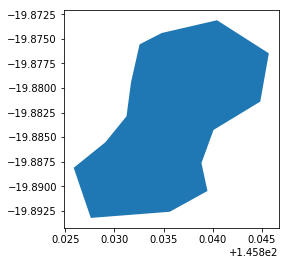

In [39]:
#plot polygon to check it looks ok
plt.clf()
shape_plot = gpd.read_file(poly_path)
shape_plot.plot()
plt.show()

### Set up query

In [38]:
query = {'geopolygon': geom,
         'time': ('2016-01-01', '2016-06-30')
         }

## Set up datasets

### load wofls and select only wet pixels

In [54]:
#define wofs
wofls = dc.load(product='wofs_albers', **query)

In [66]:
#print the number of wofs observations
len(wofls.time)

17

In [58]:
#check if boolean is ok as a total

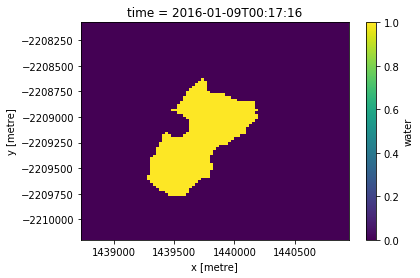

In [56]:
wetwofl = masking.make_mask(wofls, wet=True)
wetwofl.water.isel(time=0).plot()

In [63]:
#set cloudmasking threshold and load landsat nbart data
landsat_masked_prop = 0 #0.99
ls578_ds = DEADataHandling.load_clearlandsat(dc=dc, query=query, product='nbart',
        masked_prop=landsat_masked_prop)

Loading ls5 pixel quality
    Skipping ls5; no valid data for query
Ignoring SLC-off observations for ls7
Loading ls7 pixel quality
    Loading 0 filtered ls7 timesteps
Loading ls8 pixel quality
    Loading 11 filtered ls8 timesteps
Combining and sorting ls7, ls8 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)


In [147]:
#count the number of observations for ls578
len(ls578_ds)

/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/ipykernel/__main__.py:2: FutureWarning: calling len() on an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Call len() on the Dataset.variables property instead, like ``len(ds.variables)``, to preserve existing behavior in a forwards compatible manner.
  from ipykernel import kernelapp as app


10

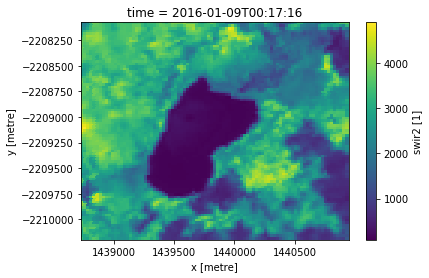

In [144]:
#plot nbart
ls578_ds.swir2.isel(time=0).plot()

In [83]:
#transform the nbart into tci
tci = TasseledCapTools.thresholded_tasseled_cap(ls578_ds,wetness_threshold=-350, drop=True , drop_tc_bands=True)

### plot the overthreshold wetness

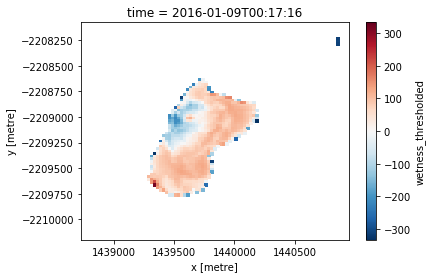

In [114]:
#plot the first time slice of wetness
tci.wetness_thresholded.isel(time=0).plot()

### create a masked version of the extent of overthreshold wetness

In [139]:
#select only finite values (over threshold values)
tcw = xr.ufuncs.isfinite(tci.wetness_thresholded)

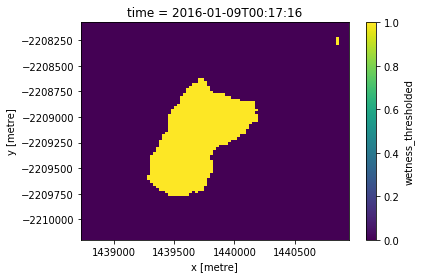

In [141]:
#plot the first timestep again to check the mask
tcw.isel(time=0).plot()

### load in fractional cover data

In [ ]:
#set cloudmasking threshold and load landsat nbart data
landsat_masked_prop = 0 #0.99
ls578_ds = DEADataHandling.load_clearlandsat(dc=dc, query=query, product='nbart',
        masked_prop=landsat_masked_prop)
#load the wofs feature layers (wofls) within the same query as Fractional cover, using 'like'
wofls = dc.load(product = 'wofs_albers', like=ds)